# Advanced Machine Learning
## Project 1 - Logistic Regression with Cyclic Coordinate Descent

---

Binda Michal, Kutak Wojciech, Legczylin Michail

### Performance of not regularized LogRegCCD against not regularized LogisticRegression

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, average_precision_score, \
    f1_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

sys.path.append("../Task2")
sys.path.append("../Task1")

from implementation.LogRegCCD import LogRegCCD
from synthetic_dataset import generate_synthetic_data

seed = 42
np.random.seed(seed)
random.seed(seed)

DATA_PATH = "../data/"

## Synthetic dataset
---

In [2]:
def compute_metrics_synthetic(model, X_train, y_train, X_test, y_test):
    """
    Computes the ROC AUC and balanced accuracy score for synthetic data.

    Parameters:
    ----------
    model: The model to use for prediction.
    X_train (numpy.ndarray): Training feature matrix.
    y_train (numpy.ndarray): Training target vector.
    X_test (numpy.ndarray): Testing feature matrix.
    y_test (numpy.ndarray): Testing target vector.

    Returns:
    ----------
    roc_auc (float): ROC AUC score.
    balanced_acc (float): Balanced accuracy score.
    """

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)
    if len(y_proba.shape) == 2:
        y_proba = y_proba[:, 1]
    y_pred = np.where(y_proba > 0.5, 1.0, 0.0)
    roc_auc = roc_auc_score(y_test, y_proba)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    return roc_auc, balanced_acc

#### 1. Balanced vs unbalanced datasets

Check how ROC and Balanced accuracy looks like. 

How harder is it to classify class $Y=1$ than $Y=0$ when there is a small number of samples per class?

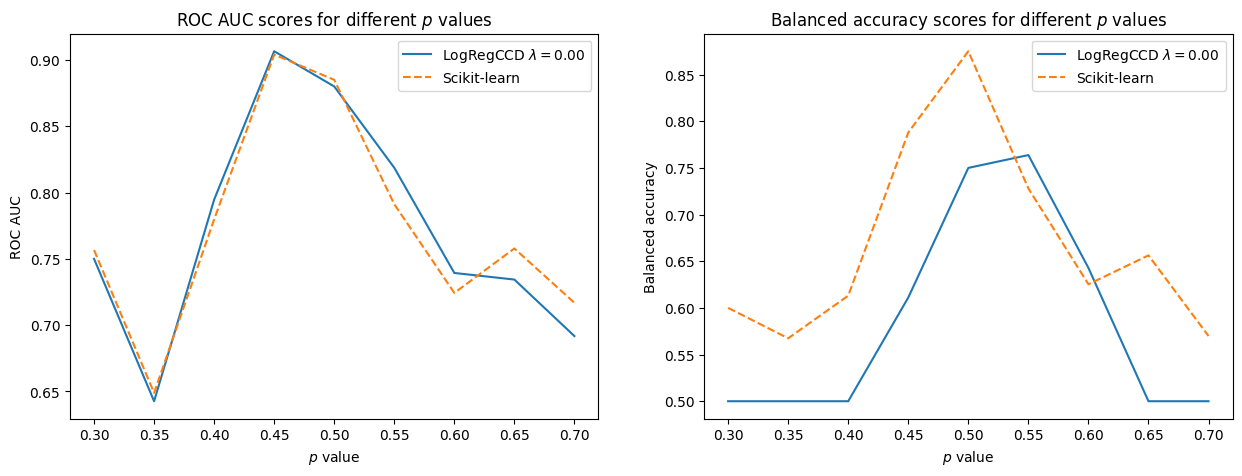

In [3]:
# Parameters for synthetic data generation
P = np.linspace(0.3, 0.7, 9, dtype=np.float32)
Lambdas = [0.0]
g = 0.2
d = 5
n = 200

legend = [f"LogRegCCD $\\lambda=${l:.2f}" for l in Lambdas]
legend.append("Scikit-learn")

plt.subplots(1, 2, figsize=(15, 5))

roc_scores = []
bal_acc_scores = []
sk_roc_scores = []
sk_bal_acc_scores = []
for idx, p in enumerate(P):
    X, y = generate_synthetic_data(p, n, d, g)
    X, y = X.to_numpy(), y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    cur_roc_scores = []
    cur_bal_acc_scores = []

    # Compute metrics for LogRegCCD
    for l in Lambdas:
        logregccd_logistic = LogRegCCD(lambda_=l)
        roc_auc, bal_acc = compute_metrics_synthetic(logregccd_logistic, X_train, y_train, X_test, y_test)
        cur_roc_scores.append(roc_auc)
        cur_bal_acc_scores.append(bal_acc)
    roc_scores.append(cur_roc_scores)
    bal_acc_scores.append(cur_bal_acc_scores)

    # Compute metrics for Scikit-learn
    logreg_sklearn = LogisticRegression(penalty=None)
    roc_auc, bal_acc = compute_metrics_synthetic(logreg_sklearn, X_train, y_train, X_test, y_test)
    sk_roc_scores.append(roc_auc)
    sk_bal_acc_scores.append(bal_acc)


# Plotting the results
plt.subplot(1, 2, 1)
plt.plot(roc_scores)
plt.plot(sk_roc_scores, "--")
plt.title(f"ROC AUC scores for different $p$ values")
plt.ylabel("ROC AUC")
plt.xlabel("$p$ value")
plt.xticks(range(len(P)), [f"{p:.2f}" for p in P])
plt.legend(legend)

plt.subplot(1, 2, 2)
plt.plot(bal_acc_scores)
plt.plot(sk_bal_acc_scores, "--")
plt.title(f"Balanced accuracy scores for different $p$ values")
plt.ylabel("Balanced accuracy")
plt.xlabel("$p$ value")
plt.xticks(range(len(P)), [f"{p:.2f}" for p in P])
plt.legend(legend)


plt.show()

#### 2. Overall small cardinality

Given that datasets are balanced, I suspect that the classification results are much worse for 
highly correlated data.

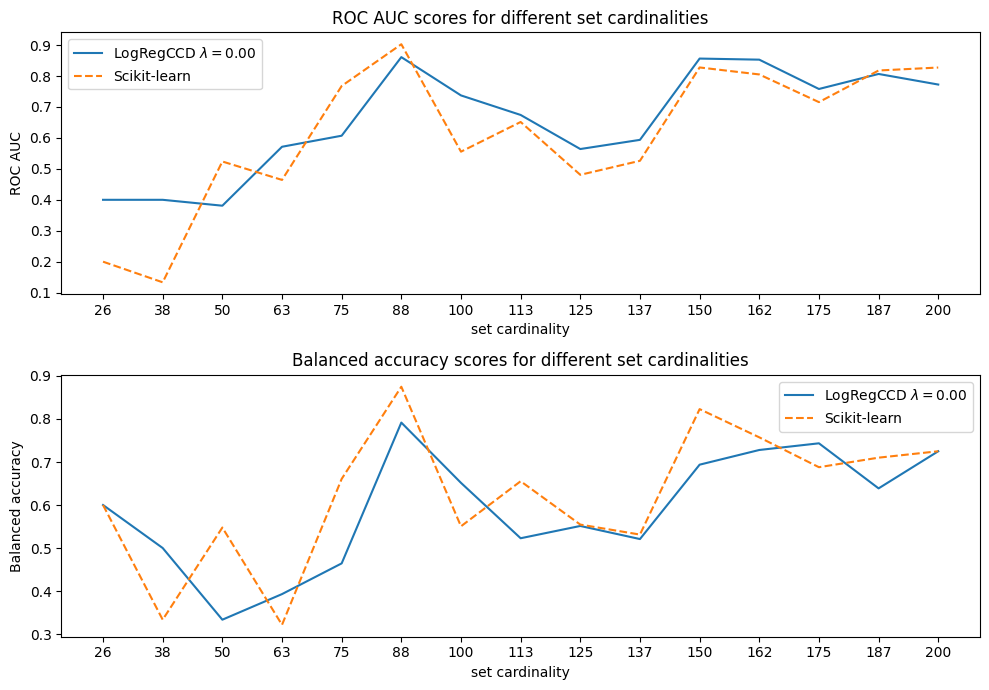

In [4]:
p = 0.5
Lambdas = [0.0]
g = 0.2
d = 25
N = np.linspace(26, 200, 15, dtype=np.int32)

legend = [f"LogRegCCD $\\lambda=${l:.2f}" for l in Lambdas]
legend.append("Scikit-learn")

plt.subplots(2, 1, figsize=(10, 7))

roc_scores = []
bal_acc_scores = []
sk_roc_scores = []
sk_bal_acc_scores = []
for n in N:
    X, y = generate_synthetic_data(p, n, d, g)
    X, y = X.to_numpy(), y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    cur_roc_scores = []
    cur_bal_acc_scores = []
    # Compute metrics for LogRegCCD
    for l in Lambdas:
        logregccd_logistic = LogRegCCD(lambda_=l)
        roc_auc, bal_acc = compute_metrics_synthetic(logregccd_logistic, X_train, y_train, X_test, y_test)
        cur_roc_scores.append(roc_auc)
        cur_bal_acc_scores.append(bal_acc)
    roc_scores.append(cur_roc_scores)
    bal_acc_scores.append(cur_bal_acc_scores)

    # Compute metrics for Scikit-learn
    logreg_sklearn = LogisticRegression(penalty=None)
    roc_auc, bal_acc = compute_metrics_synthetic(logreg_sklearn, X_train, y_train, X_test, y_test)
    sk_roc_scores.append(roc_auc)
    sk_bal_acc_scores.append(bal_acc)


# Plotting the results
plt.subplot(2, 1, 1)
plt.plot(roc_scores)
plt.plot(sk_roc_scores, "--")
plt.title(f"ROC AUC scores for different set cardinalities")
plt.ylabel("ROC AUC")
plt.xlabel("set cardinality")
plt.xticks(range(len(N)), N)
plt.legend(legend)

plt.subplot(2, 1, 2)
plt.plot(bal_acc_scores)
plt.plot(sk_bal_acc_scores, "--")
plt.title(f"Balanced accuracy scores for different set cardinalities")
plt.ylabel("Balanced accuracy")
plt.xlabel("set cardinality")
plt.xticks(range(len(N)), N)
plt.legend(legend)
plt.tight_layout()

plt.show()

### 3. Dimensionality

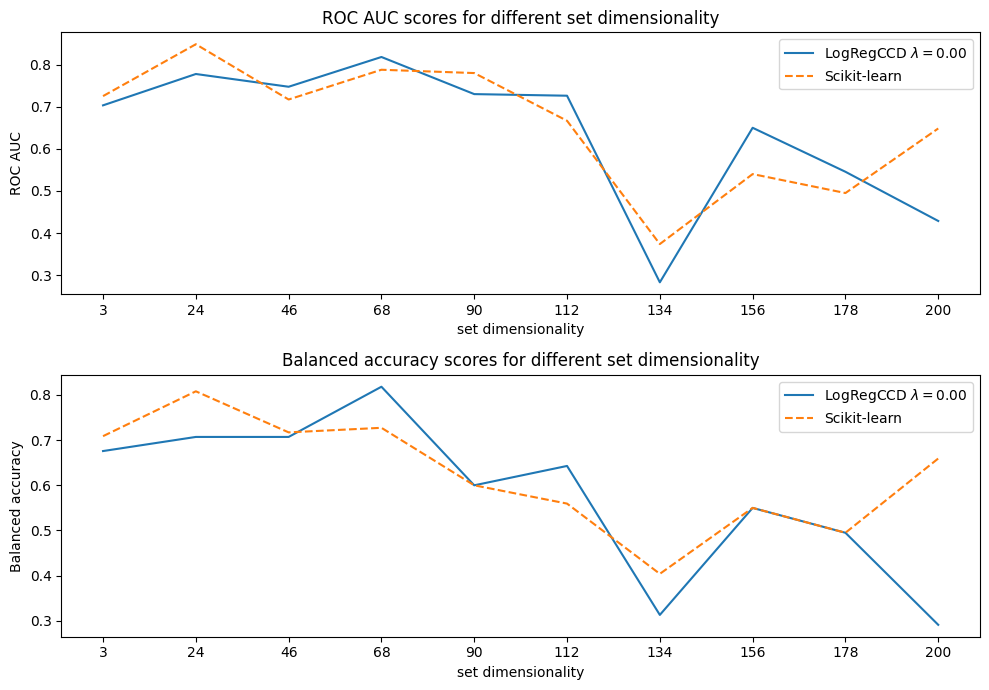

In [5]:
p = 0.5
Lambdas = [0.0]
g = 0.0
D = np.linspace(3, 200, 10, dtype=int)
n = 100

legend = [f"LogRegCCD $\\lambda=${l:.2f}" for l in Lambdas]
legend.append("Scikit-learn")

plt.subplots(2, 1, figsize=(10, 7))

roc_scores = []
bal_acc_scores = []
sk_roc_scores = []
sk_bal_acc_scores = []
for d in D:
    X, y = generate_synthetic_data(p, n, d, g)
    X, y = X.to_numpy(), y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    cur_roc_scores = []
    cur_bal_acc_scores = []
    # Compute metrics for LogRegCCD
    for l in Lambdas:
        logregccd_logistic = LogRegCCD(lambda_=l)
        roc_auc, bal_acc = compute_metrics_synthetic(logregccd_logistic, X_train, y_train, X_test, y_test)
        cur_roc_scores.append(roc_auc)
        cur_bal_acc_scores.append(bal_acc)
    roc_scores.append(cur_roc_scores)
    bal_acc_scores.append(cur_bal_acc_scores)

    # Compute metrics for Scikit-learn
    logreg_sklearn = LogisticRegression(penalty=None)
    roc_auc, bal_acc = compute_metrics_synthetic(logreg_sklearn, X_train, y_train, X_test, y_test)
    sk_roc_scores.append(roc_auc)
    sk_bal_acc_scores.append(bal_acc)


# Plotting the results
plt.subplot(2, 1, 1)
plt.plot(roc_scores)
plt.plot(sk_roc_scores, "--")
plt.title(f"ROC AUC scores for different set dimensionality")
plt.ylabel("ROC AUC")
plt.xlabel("set dimensionality")
plt.xticks(range(len(D)), D)
plt.legend(legend)

plt.subplot(2, 1, 2)
plt.plot(bal_acc_scores)
plt.plot(sk_bal_acc_scores, "--")
plt.title(f"Balanced accuracy scores for different set dimensionality")
plt.ylabel("Balanced accuracy")
plt.xlabel("set dimensionality")
plt.xticks(range(len(D)), D)
plt.legend(legend)
plt.tight_layout()

plt.show()

### 4. Correlation

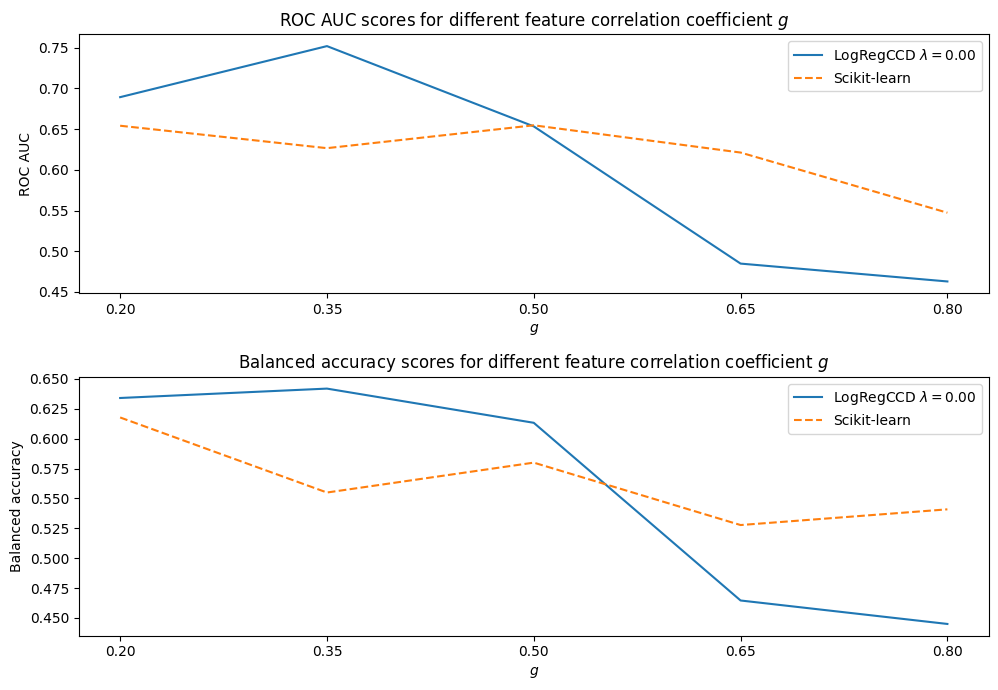

In [6]:
p = 0.5
Lambdas = [0.0]
G = np.linspace(0.2, 0.8, 5)
d = 100
n = 200

legend = [f"LogRegCCD $\\lambda=${l:.2f}" for l in Lambdas]
legend.append("Scikit-learn")

plt.subplots(2, 1, figsize=(10, 7))

roc_scores = []
bal_acc_scores = []
sk_roc_scores = []
sk_bal_acc_scores = []
for g in G:
    X, y = generate_synthetic_data(p, n, d, g)
    X, y = X.to_numpy(), y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    cur_roc_scores = []
    cur_bal_acc_scores = []
    # Compute metrics for LogRegCCD
    for l in Lambdas:
        logregccd_logistic = LogRegCCD(lambda_=l)
        roc_auc, bal_acc = compute_metrics_synthetic(logregccd_logistic, X_train, y_train, X_test, y_test)
        cur_roc_scores.append(roc_auc)
        cur_bal_acc_scores.append(bal_acc)
    roc_scores.append(cur_roc_scores)
    bal_acc_scores.append(cur_bal_acc_scores)

    # Compute metrics for Scikit-learn
    logreg_sklearn = LogisticRegression(penalty=None)
    roc_auc, bal_acc = compute_metrics_synthetic(logreg_sklearn, X_train, y_train, X_test, y_test)
    sk_roc_scores.append(roc_auc)
    sk_bal_acc_scores.append(bal_acc)


# Plotting the results
plt.subplot(2, 1, 1)
plt.plot(roc_scores)
plt.plot(sk_roc_scores, "--")
plt.title(f"ROC AUC scores for different feature correlation coefficient $g$")
plt.ylabel("ROC AUC")
plt.xlabel("$g$")
plt.xticks(range(len(G)), [f"{g:.2f}" for g in G])
plt.legend(legend)

plt.subplot(2, 1, 2)
plt.plot(bal_acc_scores)
plt.plot(sk_bal_acc_scores, "--")
plt.title(f"Balanced accuracy scores for different feature correlation coefficient $g$")
plt.ylabel("Balanced accuracy")
plt.xlabel("$g$")
plt.xticks(range(len(G)), [f"{g:.2f}" for g in G])
plt.legend(legend)
plt.tight_layout()

plt.show()

## Comparing real-world datasets
---

In [7]:
def plot_roc_curve(y_test, y_proba, label, **kwargs):
    """
    Plot ROC curve and compute AUC score.

    Parameters:
    ----------
    y_test (numpy.ndarray): True labels for the test set.
    y_proba (numpy.ndarray): Predicted probabilities for the positive class.
    label (str): Label for the plot legend.
    **kwargs: Additional keyword arguments for plotting.

    Returns:
    ----------
    roc_auc (float): AUC score.
    """

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=label +f" (AUC = {roc_auc:.2f})", **kwargs)
    return roc_auc

def plot_precision_recall_curve(y_test, y_proba, label, **kwargs):
    """
    Plot precision-recall curve and compute average precision score.

    Parameters:
    ----------
    y_test (numpy.ndarray): True labels for the test set.
    y_proba (numpy.ndarray): Predicted probabilities for the positive class.
    label (str): Label for the plot legend.
    **kwargs: Additional keyword arguments for plotting.

    Returns:
    ----------
    avg_precision (float): Average precision score.
    """

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=label + f" (AUC = {avg_precision:.2f})", **kwargs)
    return avg_precision

def compute_metrics(model, X_train, y_train, X_test, y_test, label, **kwargs):
    """
    Computes the ROC AUC and balanced accuracy score for a given model.

    Parameters:
    ----------
    model: The model to use for prediction.
    X_train (numpy.ndarray): Training feature matrix.
    y_train (numpy.ndarray): Training target vector.
    X_test (numpy.ndarray): Testing feature matrix.
    y_test (numpy.ndarray): Testing target vector.
    label (str): Label for the plot legend.
    **kwargs: Additional keyword arguments for plotting.

    Returns:
    ----------
    roc_auc (float): ROC AUC score.
    balanced_acc (float): Balanced accuracy score.
    avg_precision (float): Average precision score.
    f1 (float): F1 score.
    """

    # Fit the model
    model.fit(X_train, y_train)
    # Predict probabilities
    y_proba = model.predict_proba(X_test)

    # Check if y_proba is 2D and take the second column (probability of class 1)
    if len(y_proba.shape) == 2:
        y_proba = y_proba[:, 1]
    y_pred = np.where(y_proba > 0.5, 1.0, 0.0)

    # Compute metrics
    roc_auc = plot_roc_curve(y_test, y_proba, label, **kwargs)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    avg_precision = plot_precision_recall_curve(y_test, y_proba, label, **kwargs)
    f1 = f1_score(y_test, y_pred)
    return roc_auc, balanced_acc, avg_precision, f1

In [8]:
def process_dataset(dataset_file, title, lambdas, seed=42):
    """
    Process a dataset and compute metrics using LogRegCCD and Scikit-learn.

    Parameters:
    ----------
    dataset_file (str): Path to the dataset file.
    title (str): Title for the dataset.
    lambdas (list | None): List of lambda values for LogRegCCD. If None, lambdas will be estimated
        by LogRegCCD.
    seed (int): Random seed for reproducibility.
    """
    print(f"Processing dataset: {dataset_file} ({title})")

    # Set random seed for reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # Load the dataset
    df = pd.read_csv(os.path.join(DATA_PATH, dataset_file))
    print("Number of observations: ", df.shape[0])
    print("Number of features: ", df.shape[1])
    print("Number of classes: ", df.iloc[:, -1].nunique())
    print("Class distribution: ", df.iloc[:, -1].value_counts())
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()

    # Scale the features
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    if lambdas is None:
        C = [None]
        legend = ["LogRegCCD", "Scikit-learn"]
    else:
        C = lambdas
        legend = [f"LogRegCCD $\\lambda=${l:.1e}" for l in lambdas]
        legend.append("Scikit-learn")

    plt.subplots(2, 2, figsize=(16, 10))

    roc_scores = []
    bal_acc_scores = []
    avg_precision_scores = []
    f1_scores = []
    intercepts = []
    coefficients = []

    # Compute metrics for LogRegCCD
    for c in C:
        ccd = LogRegCCD(lambda_=c)
        roc_auc, bal_acc, avg_precision, f1 = compute_metrics(ccd, X_train, y_train,
                                                              X_test, y_test,
                                                              label=f"LogRegCCD"
                                                              + (f" $\\lambda=${(1/c):.1e}"
                                                                 if c is not None else ""))
        roc_scores.append(roc_auc)
        bal_acc_scores.append(bal_acc)
        avg_precision_scores.append(avg_precision)
        f1_scores.append(f1)
        coefficients.append(ccd.beta_)
        intercepts.append(ccd.beta0_)

    # Compute metrics for Scikit-learn
    lr_sk = LogisticRegression(penalty=None)
    sk_roc_auc, sk_bal_acc, sk_avg_precision, sk_f1 = compute_metrics(lr_sk, X_train, y_train,
                                                          X_test, y_test,
                                                          label=f"Scikit-learn",
                                                          linestyle="--")

    roc_scores.append(sk_roc_auc)
    bal_acc_scores.append(sk_bal_acc)
    avg_precision_scores.append(sk_avg_precision)
    f1_scores.append(sk_f1)
    coefficients.append(lr_sk.coef_[0])
    intercepts.append(lr_sk.intercept_[0])

    plt.subplot(2, 2, 1)
    plt.title(f"ROC curve for {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title(f"Precision-recall curve for {title}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    # Bar plot for Balanced Accuracy scores
    plt.subplot(2, 2, 3)
    bars = plt.bar(range(len(bal_acc_scores)), bal_acc_scores, tick_label=legend, color='skyblue')
    plt.title(f"Balanced Accuracy Scores for {title}")
    plt.ylabel("Balanced Accuracy")
    plt.xticks(rotation=45, ha="right")

    # Add values to bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.2f}", ha="center",
                 va="center", fontsize=10, color="black")

    # Bar plot for F1 scores
    plt.subplot(2, 2, 4)
    bars = plt.bar(range(len(f1_scores)), f1_scores, tick_label=legend, color='lightgreen')
    plt.title(f"F1 Scores for {title}")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45, ha="right")

    # Add values to bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.2f}", ha="center",
                 va="center", fontsize=10, color="black")
    plt.show()

    # Plot coefficients and intercepts
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.boxplot(coefficients, vert=True, patch_artist=True, tick_labels=legend, boxprops=dict(facecolor='lightblue'))
    plt.title(f"Boxplot of Coefficients for {title}")
    plt.xlabel("Model")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.subplot(1, 2, 2)
    bars = plt.bar(range(len(intercepts)), intercepts, tick_label=legend, color='pink')
    plt.title(f"Intercepts for {title}")
    plt.ylabel("Intercept Value")
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha="right")

    # Add values to bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.2f}", ha="center",
                 va="center", fontsize=10, color="black")
    plt.show()

    print("Coefficient statstics:")
    for i, coefs in enumerate(coefficients):
        print(f"\t{legend[i]}: mean={np.mean(coefs):.2f}, std={np.std(coefs):.2f}"
              f", min={np.min(coefs):.2f}, max={np.max(coefs):.2f}")
    print("Intercepts:")
    for i, intercept in enumerate(intercepts):
        print(f"\t{legend[i]}: {intercept:.2f}")

In [9]:
# Process DLBCL dataset
# The DLBCL dataset is a gene expression dataset for Diffuse Large B-cell Lymphoma (DLBCL).

seed = 37
lambdas = np.logspace(-6, -4, 3)
process_dataset("45088.csv", "DLBCL", lambdas, seed=seed)

Processing dataset: 45088.csv (DLBCL)


FileNotFoundError: [Errno 2] No such file or directory: '../data/45088.csv'

In [ ]:
# Process Toxicity dataset
# The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1,
# responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic.

seed = 42
lambdas = np.logspace(-5, -3, 3)
process_dataset(DATA_PATH + "46611.csv", "Toxicity", lambdas, seed=seed)

In [ ]:
# Process Colon-Kidney dataset

seed = 42
process_dataset("1137.csv", "AP Colon-Kidney", None, seed=seed)

In [ ]:
# Process Breast-Kidney dataset

seed = 42
process_dataset("1158.csv", "AP Breast-Kidney", None, seed=seed)